# scTour inference – Post-inference adjustment

## For version 1.0.0

This tutorial is for version 1.0.0 where prediction functionalities have been separated from inference. Please follow `Installation` to install the latest version (1.0.0). 

## Dataset

This notebook shows how to perform post-inference adjustment when the pseudotime and vector field estimates are returned in reverse order. The dataset from dentate gyrus neurogenesis is used here for demonstration. The data can be downloaded from [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE95315).

In [1]:
import sctour as sct
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
info = pd.read_csv('../../../../GSE95315_10X_expression_data_v2.tab', index_col=0, sep='\t', nrows=2)
count = pd.read_csv('../../../../GSE95315_10X_expression_data_v2.tab', index_col=0, sep='\t', skiprows=[1, 2]).T
adata = sc.AnnData(X=count)
adata.obs['cluster'] = info.loc['cluster_name'].values

Here the focus is the granule cell lineage.

In [3]:
ind = adata.obs['cluster'].isin(['Granule-mature', 'Granule-immature', 'Neuroblast_2', 'Neuroblast_1', 'nIPC'])
adata = adata[ind, :]
adata.shape

(4007, 14545)

Relevel the cell types and assign colors to each cell type.

In [4]:
adata.obs['cluster'] = adata.obs['cluster'].astype('category')
adata.obs['cluster'].cat.reorder_categories(['nIPC', 'Neuroblast_1', 'Neuroblast_2', 'Granule-immature', 'Granule-mature'], inplace=True)

from matplotlib import cm, colors
cols = list(map(colors.to_hex, cm.tab20.colors))
adata.uns['cluster_colors'] = ['#aa40fc'] + [cols[i] for i in [3, 2, 1, 0]]

Trying to set attribute `.obs` of view, copying.


## Model training

Count the number of genes detected in each cell. This step is required before the scTour model training.

In [5]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

Select highly variable genes.

In [6]:
sc.pp.filter_genes(adata, min_cells=20)
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=2000, subset=True)

/home/ql312/software/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


Now we are ready to train the scTour model. As shown in the `Using scTour to infer cellular dynamics` tutorial, users can adjust the parameters `alpha_recon_lec`, `alpha_recon_lode` and other parameters depending on datasets.

In [7]:
tnode = sct.train.Trainer(adata, loss_mode='nb')
tnode.train()

Epoch 400: 100%|██████████| 400/400 [15:50<00:00,  2.33s/epoch, train_loss=553, val_loss=544]


## Infer cellular dynamics

Infer the developmental pseudotime, latent space, and vector field. As shown in the `Using scTour to infer cellular dynamics` tutorial, users can adjust the two parameters `alpha_z` and `alpha_predz` for the latent representations based on their purposes.

In [8]:
##pseudotime
adata.obs['ptime'] = tnode.get_time()

##latent space
mix_zs, zs, pred_zs = tnode.get_latentsp(alpha_z=0.2, alpha_predz=0.8)
adata.obsm['X_TNODE'] = mix_zs

##vector field
adata.obsm['X_VF'] = tnode.get_vector_field(adata.obs['ptime'].values, adata.obsm['X_TNODE'])

Generate a UMAP embedding based on the latent space inferred.

In [9]:
adata = adata[np.argsort(adata.obs['ptime'].values), :]
sc.pp.neighbors(adata, use_rep='X_TNODE', n_neighbors=15)
sc.tl.umap(adata, min_dist=0.1)

Visualize the pseudotime and vector field on the UMAP.

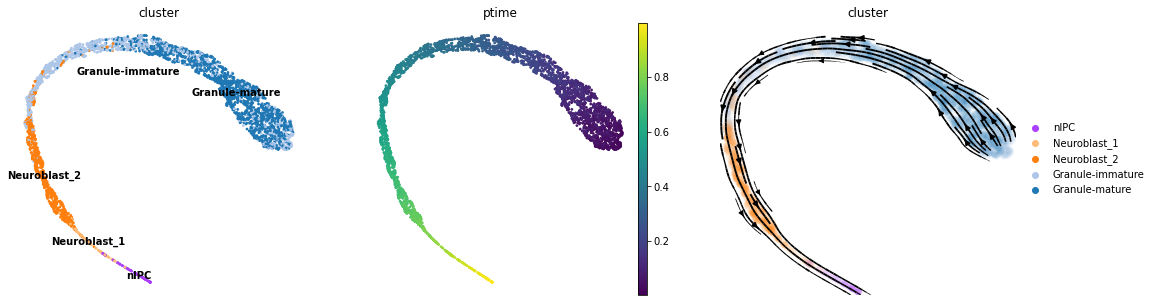

In [10]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))
sc.pl.umap(adata, color='cluster', legend_loc='on data', show=False, ax=axs[0], frameon=False)
sc.pl.umap(adata, color='ptime', show=False, ax=axs[1], frameon=False)
sct.vf.plot_vector_field(adata, zs_key='X_TNODE', vf_key='X_VF', use_rep_neigh='X_TNODE', color='cluster', show=False, ax=axs[2], frameon=False, size=200, alpha=0.05)
plt.show()

## Post-inference adjustment

Since there exist two directions for integration when solving an ODE, the returned pseudotime/vector field can be in the correct or reversed order/direction. Although scTour takes into account the gene counts which are shown to be correlated with developmental potential, this rule does not apply to all data. scTour provides a post-inference function to reverse the pseudotime/vector field estimates when such cases occur like the example shown above.

To reverse the pseudotime, please use the function `sct.train.reverse_time`.

To reverse the vector field, please set the parameter `reverse` to be `True` when visualizing it using the function `sct.vf.plot_vector_field`.

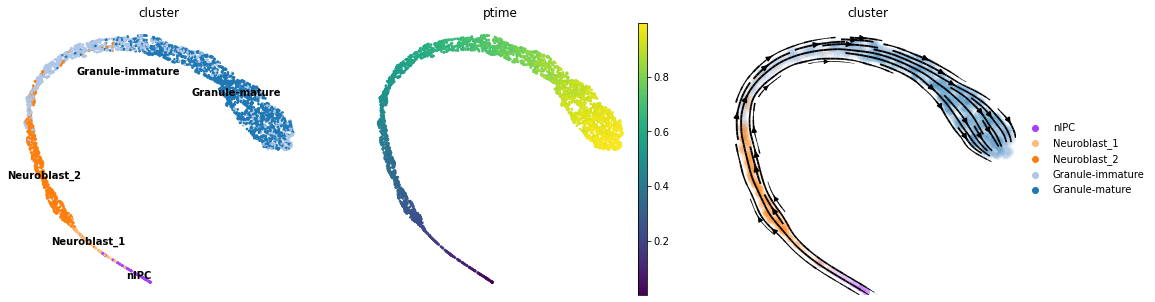

In [11]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))
sc.pl.umap(adata, color='cluster', legend_loc='on data', show=False, ax=axs[0], frameon=False)

##reverse pseudotime
adata.obs['ptime'] = sct.train.reverse_time(adata.obs['ptime'].values)
sc.pl.umap(adata, color='ptime', show=False, ax=axs[1], frameon=False)

##reverse vector field
sct.vf.plot_vector_field(adata, reverse=True, zs_key='X_TNODE', vf_key='X_VF', use_rep_neigh='X_TNODE', color='cluster', show=False, ax=axs[2], frameon=False, size=200, alpha=0.05)
plt.show()

Now the pseudotime and vector field follow the granule cell development.